In [1]:
import os
import pandas as pd
import shutil
from tqdm import tqdm
import glob
import random
from PIL import Image, ImageFile
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle
from torchvision.models import densenet121, DenseNet121_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Paths
csv_path = '/kaggle/input/data/Data_Entry_2017.csv'
image_dirs = '/kaggle/input/data/images_*/images'  # Pattern to match all image directories
output_dir = '/kaggle/working/extracted_classes'

# Allowed labels
allowed_labels = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
    "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema",
    "Fibrosis", "Pleural_Thickening", "Hernia", "No Finding"
]
allowed_labels = [label.lower() for label in allowed_labels]  # Normalize for case insensitivity

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load and filter the CSV
data = pd.read_csv(csv_path)

# Filter for images with only one label and that label is in allowed_labels
data_filtered = data[
    data['Finding Labels'].apply(
        lambda x: len(x.split('|')) == 1 and x.strip().lower() in allowed_labels
    )
]

# Gather all image paths
image_path_dict = {}
for image_dir in glob.glob(image_dirs):  # Loop through all directories
    for image_path in glob.glob(f"{image_dir}/*"):
        image_name = os.path.basename(image_path)
        image_path_dict[image_name] = image_path

# Class counts
class_counts = {label: 0 for label in allowed_labels}

# Organize images into class folders (limit to 150 per folder)
class_image_limit = 500
for _, row in tqdm(data_filtered.iterrows(), desc="Organizing images", total=len(data_filtered)):
    image_name = row['Image Index']
    label = row['Finding Labels'].strip().lower()  # Since we filtered for single-label images
    if label in class_counts:
        class_folder = os.path.join(output_dir, label.replace(' ', '_'))
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        # Limit the number of images per class
        if class_counts[label] < class_image_limit:
            src_path = image_path_dict.get(image_name)
            if src_path and os.path.exists(src_path):
                dst_path = os.path.join(class_folder, image_name)
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                    class_counts[label] += 1

# Display class counts
print("\nNumber of images per class:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


Organizing images: 100%|██████████| 91324/91324 [01:55<00:00, 789.52it/s] 


Number of images per class:
atelectasis: 500
cardiomegaly: 500
effusion: 500
infiltration: 500
mass: 500
nodule: 500
pneumonia: 322
pneumothorax: 500
consolidation: 500
edema: 500
emphysema: 500
fibrosis: 500
pleural_thickening: 500
hernia: 110
no finding: 500


In [3]:
# Define augmentations
augmentations = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation within ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Function to augment images for a specific class
def augment_class_images(class_folder, target_count):
    """
    Augments images in the class folder until the desired count is reached.

    Args:
        class_folder (str): Path to the class folder.
        target_count (int): Desired number of images after augmentation.
    """
    # List all images in the class folder
    image_paths = [os.path.join(class_folder, img) for img in os.listdir(class_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(image_paths)

    if current_count >= target_count:
        print(f"{class_folder} already has {current_count} images. No augmentation needed.")
        return

    num_to_augment = target_count - current_count
    print(f"Augmenting {num_to_augment} images for {class_folder}...")

    for i in tqdm(range(num_to_augment), desc=f"Augmenting {class_folder}"):
        # Randomly select an image
        random_image_path = random.choice(image_paths)
        with Image.open(random_image_path).convert("RGB") as img:
            # Apply augmentations
            augmented_image = augmentations(img)
            augmented_image = transforms.ToPILImage()(augmented_image)  # Convert back to PIL for saving

            # Save the augmented image
            new_image_name = f"aug_{i}_{os.path.basename(random_image_path)}"
            augmented_image.save(os.path.join(class_folder, new_image_name))

    print(f"Finished augmenting {class_folder}. Total images: {target_count}.")

# Define paths and target count for augmentation
base_dir = '/kaggle/working/extracted_classes'  # Update this path as needed
target_image_count = 1000  # Target number of images for each class

# Perform augmentation for every class
for class_name in os.listdir(base_dir):
    class_folder = os.path.join(base_dir, class_name)
    if os.path.isdir(class_folder):
        augment_class_images(class_folder, target_image_count)


Augmenting 890 images for /kaggle/working/extracted_classes/hernia...


Augmenting /kaggle/working/extracted_classes/hernia: 100%|██████████| 890/890 [05:13<00:00,  2.84it/s]


Finished augmenting /kaggle/working/extracted_classes/hernia. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/effusion...


Augmenting /kaggle/working/extracted_classes/effusion: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]


Finished augmenting /kaggle/working/extracted_classes/effusion. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/infiltration...


Augmenting /kaggle/working/extracted_classes/infiltration: 100%|██████████| 500/500 [02:53<00:00,  2.89it/s]


Finished augmenting /kaggle/working/extracted_classes/infiltration. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/cardiomegaly...


Augmenting /kaggle/working/extracted_classes/cardiomegaly: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


Finished augmenting /kaggle/working/extracted_classes/cardiomegaly. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/no_finding...


Augmenting /kaggle/working/extracted_classes/no_finding: 100%|██████████| 500/500 [02:54<00:00,  2.87it/s]


Finished augmenting /kaggle/working/extracted_classes/no_finding. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/emphysema...


Augmenting /kaggle/working/extracted_classes/emphysema: 100%|██████████| 500/500 [02:53<00:00,  2.89it/s]


Finished augmenting /kaggle/working/extracted_classes/emphysema. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/mass...


Augmenting /kaggle/working/extracted_classes/mass: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


Finished augmenting /kaggle/working/extracted_classes/mass. Total images: 1000.
Augmenting 678 images for /kaggle/working/extracted_classes/pneumonia...


Augmenting /kaggle/working/extracted_classes/pneumonia: 100%|██████████| 678/678 [03:52<00:00,  2.91it/s]


Finished augmenting /kaggle/working/extracted_classes/pneumonia. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/edema...


Augmenting /kaggle/working/extracted_classes/edema: 100%|██████████| 500/500 [02:51<00:00,  2.92it/s]


Finished augmenting /kaggle/working/extracted_classes/edema. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/consolidation...


Augmenting /kaggle/working/extracted_classes/consolidation: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]


Finished augmenting /kaggle/working/extracted_classes/consolidation. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/nodule...


Augmenting /kaggle/working/extracted_classes/nodule: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


Finished augmenting /kaggle/working/extracted_classes/nodule. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/atelectasis...


Augmenting /kaggle/working/extracted_classes/atelectasis: 100%|██████████| 500/500 [02:52<00:00,  2.89it/s]


Finished augmenting /kaggle/working/extracted_classes/atelectasis. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/pleural_thickening...


Augmenting /kaggle/working/extracted_classes/pleural_thickening: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


Finished augmenting /kaggle/working/extracted_classes/pleural_thickening. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/fibrosis...


Augmenting /kaggle/working/extracted_classes/fibrosis: 100%|██████████| 500/500 [02:52<00:00,  2.89it/s]


Finished augmenting /kaggle/working/extracted_classes/fibrosis. Total images: 1000.
Augmenting 500 images for /kaggle/working/extracted_classes/pneumothorax...


Augmenting /kaggle/working/extracted_classes/pneumothorax: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]

Finished augmenting /kaggle/working/extracted_classes/pneumothorax. Total images: 1000.


In [4]:
# Define the main dataset directory (where images are stored by class)
dataset_dir = '/kaggle/working/extracted_classes'

# Output directories for splits
train_dir = '/kaggle/working/split/train'
val_dir = '/kaggle/working/split/val'
test_dir = '/kaggle/working/split/test'

# Create directories for splits
for split_dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Iterate through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    # Ensure it's a directory
    if os.path.isdir(class_path):
        # Get all image file names in this class
        images = os.listdir(class_path)
        
        # Split the data into train, val, and test sets
        train_images, temp_images = train_test_split(
            images, test_size=(val_ratio + test_ratio), random_state=42
        )
        val_images, test_images = train_test_split(
            temp_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42
        )
        
        # Create class-specific subdirectories in the splits
        for split_name, split_images in zip(
            ["train", "val", "test"], [train_images, val_images, test_images]
        ):
            split_class_dir = os.path.join(
                eval(f"{split_name}_dir"), class_name
            )
            if not os.path.exists(split_class_dir):
                os.makedirs(split_class_dir)
            
            # Move images to the respective split folder
            for image_name in tqdm(
                split_images, desc=f"Moving {split_name} images for class {class_name}"
            ):
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(split_class_dir, image_name)
                shutil.move(src_path, dst_path)  # Move instead of copy

        # Remove the original class folder if it's empty
        if not os.listdir(class_path):
            os.rmdir(class_path)  # Delete the empty folder

print("Dataset successfully split and original files moved.")


Moving test images for class pneumothorax: 100%|██████████| 101/101 [00:00<00:00, 39173.73it/s]

Dataset successfully split and original files moved.


In [5]:
# Define the allowed labels
allowed_labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "No_Finding",
    "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
]
label_to_index = {label.lower(): idx for idx, label in enumerate(allowed_labels)}

# Function to generate multi-hot labels
def generate_labels(image_folder, label_to_index):
    image_paths = []
    labels = []

    for label in os.listdir(image_folder):
        label_path = os.path.join(image_folder, label)
        if os.path.isdir(label_path):  # Check if it's a directory
            for image in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, image))

                # Generate multi-hot encoding for the current label
                multi_hot_label = torch.zeros(len(label_to_index), dtype=torch.float32)
                multi_hot_label[label_to_index[label.lower()]] = 1.0
                labels.append(multi_hot_label)

    return image_paths, labels

# Define the dataset split directories
train_dir = '/kaggle/working/split/train'
val_dir = '/kaggle/working/split/val'
test_dir = '/kaggle/working/split/test'

# Generate paths and labels for each split
train_image_paths, train_labels = generate_labels(train_dir, label_to_index)
val_image_paths, val_labels = generate_labels(val_dir, label_to_index)
test_image_paths, test_labels = generate_labels(test_dir, label_to_index)

# Verify the output
print(f"Train: {len(train_image_paths)} images, {len(train_labels)} labels")
print(f"Validation: {len(val_image_paths)} images, {len(val_labels)} labels")
print(f"Test: {len(test_image_paths)} images, {len(test_labels)} labels")


Train: 10485 images, 10485 labels
Validation: 3000 images, 3000 labels
Test: 1515 images, 1515 labels


In [7]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
num_epochs = 30
learning_rate = 0.001
batch_size = 8
num_classes = 15

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Custom dataset class (adjust paths and labels for your dataset)
class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")

        # Clone and detach labels (fix for the warning)
        label = self.labels[idx].clone().detach()

        # Apply transforms if available
        if self.transform:
            image = self.transform(image)

        return image, label

# Initialize datasets and dataloaders
train_dataset = ChestXRayDataset(train_image_paths, train_labels, transform=data_transforms['train'])
val_dataset = ChestXRayDataset(val_image_paths, val_labels, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = densenet121()

# Modify the classifier to match the dataset
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the checkpoint
checkpoint_path = "/kaggle/input/chexnet_weights/tensorflow2/default/1/model.pth.tar"
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
if "state_dict" in checkpoint:
    checkpoint["state_dict"] = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
    model.load_state_dict(checkpoint["state_dict"], strict=False)
else:
    model.load_state_dict(checkpoint, strict=False)

# Ensure the last dense block is unfrozen
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Transfer the model to the appropriate device
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# During validation/inference, apply sigmoid for probabilities
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Sigmoid for probabilities (optional for metrics)
            probabilities = torch.sigmoid(outputs)

    val_loss /= len(val_loader)
    return val_loss

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, verbose=True):
        """
        Args:
            patience (int): Number of epochs to wait after the last improvement.
            delta (float): Minimum change to qualify as an improvement.
            verbose (bool): Print messages if enabled.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience} epochs with no improvement.")
            if self.counter >= self.patience:
                self.early_stop = True

# Training function with early stopping and checkpoint saving
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Validation step
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save checkpoint after every epoch
        checkpoint_path = f'/kaggle/working/densenet121_epoch{epoch+1}.pth'
        torch.save({
            'epoch': epoch + 1,  # Save the current epoch
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Training stopped.")
            break


# Train the model
save_path = '/kaggle/working/densenet121_multilabel.pth'
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, patience=5)

/tmp/ipykernel_30/2124367565.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_

Epoch 1/30, Train Loss: 0.2445, Validation Loss: 0.2390
Checkpoint saved to /kaggle/working/densenet121_epoch1.pth


Epoch 2/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.44it/s]


Epoch 2/30, Train Loss: 0.2414, Validation Loss: 0.2377
Checkpoint saved to /kaggle/working/densenet121_epoch2.pth


Epoch 3/30: 100%|██████████| 1311/1311 [06:22<00:00,  3.43it/s]


Epoch 3/30, Train Loss: 0.2361, Validation Loss: 0.2333
Checkpoint saved to /kaggle/working/densenet121_epoch3.pth


Epoch 4/30: 100%|██████████| 1311/1311 [06:25<00:00,  3.40it/s]


Epoch 4/30, Train Loss: 0.2335, Validation Loss: 0.2339
Checkpoint saved to /kaggle/working/densenet121_epoch4.pth
EarlyStopping: 1/5 epochs with no improvement.


Epoch 5/30: 100%|██████████| 1311/1311 [06:23<00:00,  3.42it/s]


Epoch 5/30, Train Loss: 0.2319, Validation Loss: 0.2302
Checkpoint saved to /kaggle/working/densenet121_epoch5.pth


Epoch 6/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.43it/s]


Epoch 6/30, Train Loss: 0.2301, Validation Loss: 0.2299
Checkpoint saved to /kaggle/working/densenet121_epoch6.pth
EarlyStopping: 1/5 epochs with no improvement.


Epoch 7/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.44it/s]


Epoch 7/30, Train Loss: 0.2282, Validation Loss: 0.2273
Checkpoint saved to /kaggle/working/densenet121_epoch7.pth


Epoch 8/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.43it/s]


Epoch 8/30, Train Loss: 0.2255, Validation Loss: 0.2250
Checkpoint saved to /kaggle/working/densenet121_epoch8.pth


Epoch 9/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.43it/s]


Epoch 9/30, Train Loss: 0.2231, Validation Loss: 0.2244
Checkpoint saved to /kaggle/working/densenet121_epoch9.pth
EarlyStopping: 1/5 epochs with no improvement.


Epoch 10/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.44it/s]


Epoch 10/30, Train Loss: 0.2198, Validation Loss: 0.2250
Checkpoint saved to /kaggle/working/densenet121_epoch10.pth
EarlyStopping: 2/5 epochs with no improvement.


Epoch 11/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.43it/s]


Epoch 11/30, Train Loss: 0.2165, Validation Loss: 0.2205
Checkpoint saved to /kaggle/working/densenet121_epoch11.pth


Epoch 12/30: 100%|██████████| 1311/1311 [06:20<00:00,  3.44it/s]


Epoch 12/30, Train Loss: 0.2128, Validation Loss: 0.2210
Checkpoint saved to /kaggle/working/densenet121_epoch12.pth
EarlyStopping: 1/5 epochs with no improvement.


Epoch 13/30: 100%|██████████| 1311/1311 [06:19<00:00,  3.45it/s]


Epoch 13/30, Train Loss: 0.2086, Validation Loss: 0.2193
Checkpoint saved to /kaggle/working/densenet121_epoch13.pth


Epoch 14/30: 100%|██████████| 1311/1311 [06:20<00:00,  3.45it/s]


Epoch 14/30, Train Loss: 0.2035, Validation Loss: 0.2196
Checkpoint saved to /kaggle/working/densenet121_epoch14.pth
EarlyStopping: 1/5 epochs with no improvement.


Epoch 15/30: 100%|██████████| 1311/1311 [06:20<00:00,  3.44it/s]


Epoch 15/30, Train Loss: 0.1980, Validation Loss: 0.2207
Checkpoint saved to /kaggle/working/densenet121_epoch15.pth
EarlyStopping: 2/5 epochs with no improvement.


Epoch 16/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.44it/s]


Epoch 16/30, Train Loss: 0.1921, Validation Loss: 0.2232
Checkpoint saved to /kaggle/working/densenet121_epoch16.pth
EarlyStopping: 3/5 epochs with no improvement.


Epoch 17/30: 100%|██████████| 1311/1311 [06:21<00:00,  3.44it/s]


Epoch 17/30, Train Loss: 0.1840, Validation Loss: 0.2244
Checkpoint saved to /kaggle/working/densenet121_epoch17.pth
EarlyStopping: 4/5 epochs with no improvement.


Epoch 18/30: 100%|██████████| 1311/1311 [06:19<00:00,  3.46it/s]


Epoch 18/30, Train Loss: 0.1777, Validation Loss: 0.2250
Checkpoint saved to /kaggle/working/densenet121_epoch18.pth
EarlyStopping: 5/5 epochs with no improvement.
Early stopping triggered. Training stopped.


In [14]:
import os
import shutil

os.remove("/kaggle/working/split.zip")
shutil.rmtree("/kaggle/working/extracted_classes")

In [ ]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
num_epochs = 70  # Total number of epochs to run
learning_rate = 0.0001
batch_size = 8
num_classes = 15
save_epoch = 5  # Specify the epoch to save the model
checkpoint_path = '/kaggle/working/densenet121_epoch44.pth'  # Path to resume checkpoint

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Custom dataset class (adjust paths and labels for your dataset)
class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")

        # Clone and detach labels
        label = self.labels[idx].clone().detach()

        # Apply transforms if available
        if self.transform:
            image = self.transform(image)

        return image, label

# Initialize datasets and dataloaders
train_dataset = ChestXRayDataset(train_image_paths, train_labels, transform=data_transforms['train'])
val_dataset = ChestXRayDataset(val_image_paths, val_labels, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = densenet121()

# Modify the classifier to match the dataset
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the checkpoint (if available)
start_epoch = 0  # Default to training from scratch
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-4)

if os.path.exists(checkpoint_path):
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resumed from epoch {start_epoch}")

# Ensure the last dense block is unfrozen
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Transfer the model to the appropriate device
model = model.to(device)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# During validation/inference, apply sigmoid for probabilities
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    return val_loss

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience} epochs with no improvement.")
            if self.counter >= self.patience:
                self.early_stop = True

# Training function with early stopping and saving on the 5th epoch
def train_model_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, start_epoch, num_epochs, save_path, save_epoch, patience=10
):
    early_stopping = EarlyStopping(patience=patience)
    final_val_loss = None  # To store the latest validation loss

    # Move optimizer state tensors to the correct device
    for state in optimizer.state.values():
        if isinstance(state, dict):  # Optimizer states can be nested dictionaries
            for key, value in state.items():
                if isinstance(value, torch.Tensor):
                    state[key] = value.to(device)

    model.train()

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move images and labels to the correct device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Validation step
        val_loss = validate_model(model, val_loader, criterion)
        train_loss = running_loss / len(train_loader)
        final_val_loss = val_loss  # Store the latest validation loss

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save checkpoint on the specified epoch or the final epoch
        if epoch + 1 == save_epoch or epoch + 1 == num_epochs:
            current_save_path = f'/kaggle/working/densenet121_epoch{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,  # Save the current epoch
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, current_save_path)
            print(f"Checkpoint saved to {current_save_path}")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Training stopped.")

            # Dynamically update the save path for the early stopping epoch
            early_stop_save_path = f'/kaggle/working/densenet121_epoch{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,  # Save the current epoch
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, early_stop_save_path)
            print(f"Checkpoint saved to {early_stop_save_path} (early stopping)")
            break

    return final_val_loss  # Return the latest validation loss

# Train the model
save_path = f'/kaggle/working/densenet121_epoch{save_epoch}.pth'
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, start_epoch, num_epochs, save_path, save_epoch, patience=10)


Resuming training from checkpoint: /kaggle/working/densenet121_epoch44.pth


/tmp/ipykernel_30/2595673563.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Resumed from epoch 44


Epoch 45/70: 100%|██████████| 1311/1311 [06:31<00:00,  3.35it/s]


Epoch 45/70, Train Loss: 0.2187, Validation Loss: 0.2177


Epoch 46/70: 100%|██████████| 1311/1311 [06:23<00:00,  3.42it/s]


Epoch 46/70, Train Loss: 0.1833, Validation Loss: 0.2161


Epoch 47/70: 100%|██████████| 1311/1311 [06:24<00:00,  3.41it/s]


Epoch 47/70, Train Loss: 0.1651, Validation Loss: 0.2146


Epoch 48/70: 100%|██████████| 1311/1311 [06:22<00:00,  3.43it/s]


Epoch 48/70, Train Loss: 0.1548, Validation Loss: 0.2216
EarlyStopping: 1/10 epochs with no improvement.


Epoch 49/70: 100%|██████████| 1311/1311 [06:23<00:00,  3.42it/s]


Epoch 49/70, Train Loss: 0.1473, Validation Loss: 0.2208
EarlyStopping: 2/10 epochs with no improvement.


Epoch 50/70:   6%|▌         | 77/1311 [00:22<05:54,  3.48it/s]

/tmp/ipykernel_30/3239214709.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Predictions for Random Test Images:

Image: /kaggle/working/split/test/nodule/aug_98_00001832_001.png
Predicted Classes and Probabilities:
Atelectasis: 0.0080
Cardiomegaly: 0.0029
Consolidation: 0.0757
Edema: 0.0025
Effusion: 0.0020
Emphysema: 0.3111
Fibrosis: 0.3300
Hernia: 0.0509
Infiltration: 0.0377
Mass: 0.0065
No_Finding: 0.0400
Nodule: 0.0862
Pleural_Thickening: 0.0217
Pneumonia: 0.0637
Pneumothorax: 0.0035


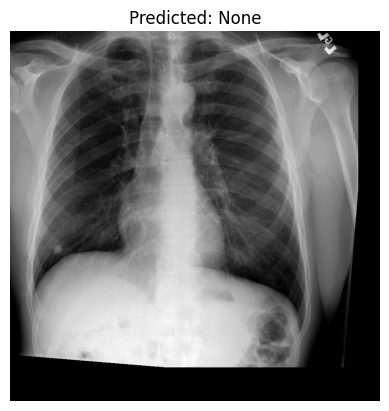


Image: /kaggle/working/split/test/consolidation/00008397_002.png
Predicted Classes and Probabilities:
Atelectasis: 0.0018
Cardiomegaly: 0.0002
Consolidation: 0.0493
Edema: 0.1198
Effusion: 0.0187
Emphysema: 0.3287
Fibrosis: 0.0059
Hernia: 0.0000
Infiltration: 0.0535
Mass: 0.4241
No_Finding: 0.0002
Nodule: 0.0069
Pleural_Thickening: 0.0670
Pneumonia: 0.0035
Pneumothorax: 0.2658


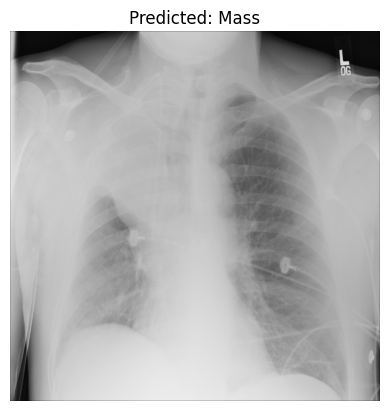


Image: /kaggle/working/split/test/no_finding/aug_403_00000151_002.png
Predicted Classes and Probabilities:
Atelectasis: 0.0099
Cardiomegaly: 0.0055
Consolidation: 0.0025
Edema: 0.0132
Effusion: 0.0109
Emphysema: 0.0235
Fibrosis: 0.0605
Hernia: 0.0011
Infiltration: 0.0264
Mass: 0.0428
No_Finding: 0.0707
Nodule: 0.0282
Pleural_Thickening: 0.1511
Pneumonia: 0.0327
Pneumothorax: 0.0214


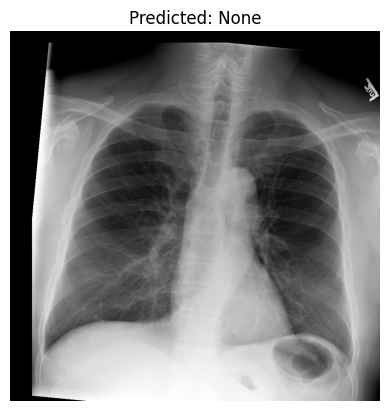


Image: /kaggle/working/split/test/pleural_thickening/aug_30_00002826_000.png
Predicted Classes and Probabilities:
Atelectasis: 0.0409
Cardiomegaly: 0.0102
Consolidation: 0.0351
Edema: 0.0061
Effusion: 0.0173
Emphysema: 0.0088
Fibrosis: 0.0827
Hernia: 0.0046
Infiltration: 0.0869
Mass: 0.0341
No_Finding: 0.0124
Nodule: 0.1667
Pleural_Thickening: 0.2655
Pneumonia: 0.0019
Pneumothorax: 0.0214


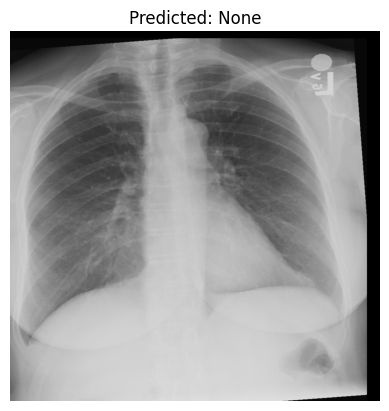


Image: /kaggle/working/split/test/fibrosis/aug_341_00006832_011.png
Predicted Classes and Probabilities:
Atelectasis: 0.0071
Cardiomegaly: 0.0334
Consolidation: 0.0144
Edema: 0.0002
Effusion: 0.2389
Emphysema: 0.0986
Fibrosis: 0.2387
Hernia: 0.0061
Infiltration: 0.0002
Mass: 0.0782
No_Finding: 0.0356
Nodule: 0.0912
Pleural_Thickening: 0.1515
Pneumonia: 0.0254
Pneumothorax: 0.0010


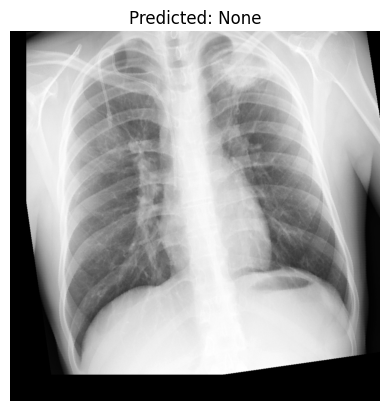


Image: /kaggle/working/split/test/emphysema/aug_27_00009646_000.png
Predicted Classes and Probabilities:
Atelectasis: 0.0005
Cardiomegaly: 0.1017
Consolidation: 0.0060
Edema: 0.0000
Effusion: 0.2396
Emphysema: 0.1355
Fibrosis: 0.0991
Hernia: 0.0040
Infiltration: 0.0000
Mass: 0.0934
No_Finding: 0.0135
Nodule: 0.0014
Pleural_Thickening: 0.0601
Pneumonia: 0.0051
Pneumothorax: 0.0036


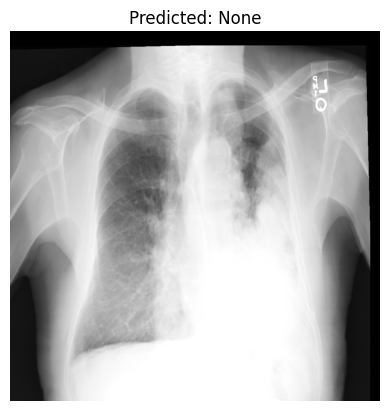


Image: /kaggle/working/split/test/no_finding/00000254_001.png
Predicted Classes and Probabilities:
Atelectasis: 0.0241
Cardiomegaly: 0.0008
Consolidation: 0.0004
Edema: 0.0002
Effusion: 0.0009
Emphysema: 0.3329
Fibrosis: 0.0557
Hernia: 0.0027
Infiltration: 0.0046
Mass: 0.1016
No_Finding: 0.1268
Nodule: 0.0301
Pleural_Thickening: 0.2822
Pneumonia: 0.0006
Pneumothorax: 0.0023


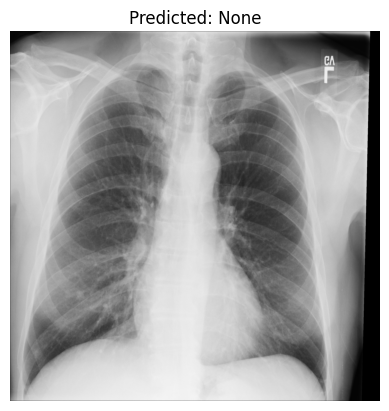


Image: /kaggle/working/split/test/pneumonia/aug_632_00002288_004.png
Predicted Classes and Probabilities:
Atelectasis: 0.0420
Cardiomegaly: 0.0306
Consolidation: 0.0112
Edema: 0.0019
Effusion: 0.0280
Emphysema: 0.0198
Fibrosis: 0.0154
Hernia: 0.0000
Infiltration: 0.0245
Mass: 0.1290
No_Finding: 0.0503
Nodule: 0.0580
Pleural_Thickening: 0.0533
Pneumonia: 0.0051
Pneumothorax: 0.0097


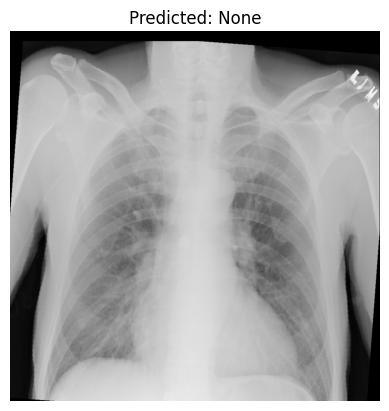


Image: /kaggle/working/split/test/emphysema/aug_379_00005826_000.png
Predicted Classes and Probabilities:
Atelectasis: 0.0709
Cardiomegaly: 0.1034
Consolidation: 0.0125
Edema: 0.0011
Effusion: 0.0151
Emphysema: 0.0296
Fibrosis: 0.0516
Hernia: 0.0059
Infiltration: 0.0017
Mass: 0.0850
No_Finding: 0.0509
Nodule: 0.0078
Pleural_Thickening: 0.0807
Pneumonia: 0.0545
Pneumothorax: 0.0049


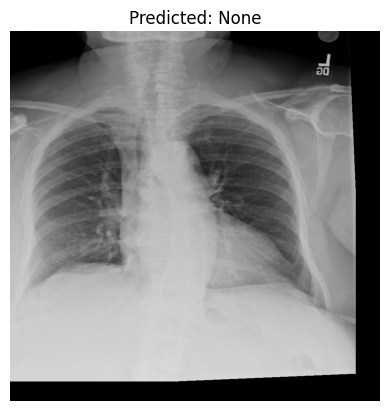


Image: /kaggle/working/split/test/mass/aug_390_00004465_000.png
Predicted Classes and Probabilities:
Atelectasis: 0.0041
Cardiomegaly: 0.2245
Consolidation: 0.0098
Edema: 0.0017
Effusion: 0.0410
Emphysema: 0.0002
Fibrosis: 0.0177
Hernia: 0.0000
Infiltration: 0.0268
Mass: 0.7051
No_Finding: 0.0100
Nodule: 0.1831
Pleural_Thickening: 0.0490
Pneumonia: 0.0020
Pneumothorax: 0.0456


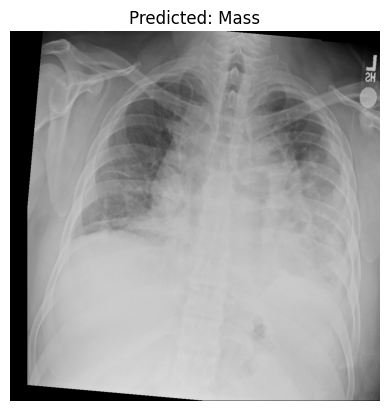

In [33]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
num_classes = 15  # Update this based on your dataset
model = densenet121(weights=None)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)  # Match the training structure
model = model.to(device)

# Load the saved weights
checkpoint_path = '/kaggle/working/densenet121_epoch44.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()  # Set the model to evaluation mode

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the class labels
class_labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "No_Finding",
    "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
]

# Define the test folder
test_folder = '/kaggle/working/split/test'

# Randomly select a set of images from the test folder
def get_random_test_images(folder, num_images=10):
    image_paths = []
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            image_paths.extend(class_images)
    # Randomly select a subset of images
    return random.sample(image_paths, min(len(image_paths), num_images))

# Get random images from the test folder
num_images_to_test = 10  # Specify the number of images to test
random_images = get_random_test_images(test_folder, num_images_to_test)

# Make predictions on the selected images
threshold = 0.4  # Set the threshold for multi-label classification

print("Predictions for Random Test Images:")
for image_path in random_images:
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_tensor)
    predicted_probs = torch.sigmoid(outputs).cpu().squeeze().numpy()

    # Determine the predicted classes
    predicted_classes = [class_labels[i] for i, prob in enumerate(predicted_probs) if prob > threshold]

    # Print the predictions
    print(f"\nImage: {image_path}")
    print("Predicted Classes and Probabilities:")

    # Print each class with its probability
    for class_name, prob in zip(class_labels, predicted_probs):
        print(f"{class_name}: {prob:.4f}")

    # Visualize the image with predictions
    plt.imshow(image)
    plt.title(f"Predicted: {', '.join(predicted_classes) if predicted_classes else 'None'}")
    plt.axis('off')
    plt.show()

In [13]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the class labels
class_labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "No_Finding",
    "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
]

# Load the model
num_classes = len(class_labels)
model = densenet121(weights=None)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, num_classes),
    torch.nn.Sigmoid()  # Sigmoid for multi-label classification
)
model = model.to(device)

# Load the saved weights
model_path = '/kaggle/working/densenet121_multilabel.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Function to load test images and labels
def load_test_data(test_folder):
    image_paths = []
    true_labels = []
    for class_idx, class_name in enumerate(class_labels):
        class_path = os.path.join(test_folder, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, image_name))
                # Create a multi-hot encoded label for the image
                label = np.zeros(num_classes, dtype=np.float32)
                label[class_idx] = 1.0  # Mark the current class as 1
                true_labels.append(label)
    return image_paths, true_labels

# Define test folder path
test_folder = '/kaggle/working/split/test'

# Load test data
test_image_paths, test_true_labels = load_test_data(test_folder)

# Evaluate the model
def evaluate_model(model, test_image_paths, test_true_labels, threshold=0.5):
    all_predictions = []
    all_targets = []

    for image_path, true_label in tqdm(zip(test_image_paths, test_true_labels), total=len(test_image_paths), desc="Evaluating"):
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Get model prediction
        with torch.no_grad():
            output = model(input_tensor)
        predicted_probs = output.cpu().squeeze().numpy()

        # Apply threshold to convert probabilities to binary predictions
        predicted_labels = (predicted_probs > threshold).astype(int)

        all_predictions.append(predicted_labels)
        all_targets.append(true_label)

    # Convert to numpy arrays for metrics calculation
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

    print(f"Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Evaluate the model on test data
evaluate_model(model, test_image_paths, test_true_labels)


/tmp/ipykernel_30/1689234644.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Evaluating: 0it [00:00, ?it/s]

Model Evaluation Metrics:
Accuracy: nan
Precision: nan
Recall: nan
F1-Score: nan



/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: 